In [1]:
import pandas as pd
import numpy as np
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score, cross_val_predict
import xgboost as xgb
import lightgbm as lgb
from tabpfn import TabPFNClassifier
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
import optuna
import plotly.graph_objects as go
import seaborn as sns


In [2]:
df_completo = pd.read_csv(r"C:\Users\alefs\OneDrive\Documentos\GitHub\tcp\01_dados\data_mobilidade.csv")

list(df_completo.columns)

['Unnamed: 0',
 'id',
 'id_seq',
 'transicao',
 'renda_depois',
 'idade',
 'genero',
 'UF',
 'escolaridade',
 'raça',
 'posicao_familiar',
 'regiao']

In [3]:
df_completo = df_completo.drop(['Unnamed: 0', 'renda_depois', 'UF', 'id', 'id_seq'], axis = "columns")
df_completo['transicao'] = df_completo['transicao'].map({'Migrou para TCP': 1, "Migrou para o setor privado": 0})
df_completo['genero'] = df_completo['genero'].map({'Homem': 1, "Mulher": 0})
df_completo['escolaridade'] = df_completo['escolaridade'].map({'Ensino médio completo': 1, "Ensino médio incompleto": 0})
df_completo['raça'] = df_completo['raça'].map({'Branco': 1, 'Não branco': 0})
df_completo['posicao_familiar'] = df_completo['posicao_familiar'].map({'Responsável pelo domicílio': 1,
                                                                      'Não responsável pelo domicílio': 0})

# Encoder
drop_enc = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Ajuste e transformação
df_completo_encoded = pd.DataFrame(
    drop_enc.fit_transform(df_completo[['regiao']]),
    columns=drop_enc.get_feature_names_out(['regiao']),
    index=df_completo.index
)

# Substituir no original
df_encod = df_completo.drop(columns=['regiao']).join(df_completo_encoded)

df_encod

,transicao,idade,genero,escolaridade,raça,posicao_familiar,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul
0,0,20,0,1,0,0,0.0,1.0,0.0,0.0
1,0,40,0,1,0,0,0.0,1.0,0.0,0.0
2,1,27,0,0,0,0,0.0,1.0,0.0,0.0
3,0,19,0,1,0,0,0.0,1.0,0.0,0.0
4,0,26,1,1,1,0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
558,1,29,1,1,1,0,0.0,0.0,0.0,0.0
559,0,18,0,1,0,0,0.0,0.0,0.0,0.0
560,1,33,0,1,0,0,0.0,0.0,0.0,0.0
561,1,38,1,1,0,0,0.0,0.0,0.0,0.0


In [4]:
x = df_encod.drop(columns=['transicao'])
y = df_encod['transicao'] 

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state = 42)

In [21]:
smote = SMOTE(sampling_strategy = 'auto', random_state = 42)
X_train_balanceado, y_train_balanceado = smote.fit_resample(X_train, y_train)

In [42]:
resultados_trials = []

def objective(trial):
    
    model_name = trial.suggest_categorical('model_name', [
        'Logistic Regression',
        'Decision Tree',
        'Random Forest',
        'LightGBM',
        'AdaBoost'     
    ])
    
    # Inicialização do modelo
    model = None
    
    if model_name == 'Logistic Regression':
        C = trial.suggest_float('logreg', 1e-3, 10, log=True)
        model = LogisticRegression(C=C, solver='lbfgs', 
                                   max_iter=1000, 
                                   random_state=42)
        
    elif model_name == 'Decision Tree':
        max_depth = trial.suggest_int("dt_max_depth", 2, 32)
        min_samples_split = trial.suggest_int('dt_min_sample_split', 2, 10)
        model = DecisionTreeClassifier(max_depth=max_depth, 
                                       min_samples_split=min_samples_split, 
                                       random_state=42)
        
    elif model_name == 'Random Forest':
        n_estimators = trial.suggest_int('rf_n_estimators', 50, 300)
        max_depth = trial.suggest_int('rf_max_depth', 2, 32)
        model = RandomForestClassifier(n_estimators=n_estimators, 
                                       max_depth=max_depth, 
                                       random_state=42)
        
    elif model_name == "LightGBM":
        n_estimators = trial.suggest_int("lgb_n_estimators", 50, 300)
        max_depth = trial.suggest_int("lgb_max_depth", 3, 10)
        learning_rate = trial.suggest_float("lgb_learning_rate", 0.01, 0.3)
        model = lgb.LGBMClassifier(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    learning_rate=learning_rate,
                                    random_state=42)
        
    elif model_name == 'AdaBoost':
        n_estimators = trial.suggest_int('ada_n_estimators', 50, 300)
        learning_rate = trial.suggest_float('ada_learning_rate', 0.01, 1)
        model = AdaBoostClassifier(n_estimators=n_estimators,
                                   learning_rate=learning_rate,
                                   random_state=42)

    #Cross-validation
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    y_pred_proba = cross_val_predict(model, X_train_balanceado, y_train_balanceado, cv = skf, method='predict_proba')
    y_pred = np.argmax(y_pred_proba, axis = 1)
    
    #Métricas
    acc = accuracy_score(y_train_balanceado, y_pred)
    prec = precision_score(y_train_balanceado, y_pred, average = 'macro')
    rec = recall_score(y_train_balanceado, y_pred, average = 'macro')
    f1 = f1_score(y_train_balanceado, y_pred, average = 'macro')
    logloss = log_loss(y_train_balanceado, y_pred_proba)
    roc_auc = roc_auc_score(y_train_balanceado, y_pred_proba[:, 1])
    
    # Armazenar resultados
    resultados_trials.append({
        'model_name': model_name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'log_loss': logloss,
        'roc_auc': roc_auc,
        **trial.params
    })

    return roc_auc  # porque optuna está maximizando

In [43]:
# Criando o objeto de estudo
study = optuna.create_study(direction='maximize',
                           sampler=optuna.samplers.TPESampler(seed=42))

# Iniciando a busca de hiperparâmetros
study.optimize(objective, n_trials=50)

# Mostra os resultados
print("Melhores hiperparâmetros:", study.best_trial.params)

#Transformando resultados em DataFrame
df_resultados = pd.DataFrame(resultados_trials)

#Ordenando pelo log-loss
df_resultados_ordenado = df_resultados.sort_values(by='roc_auc', ascending=False)
print(df_resultados_ordenado.head(10))

[I 2025-04-17 14:16:42,921] A new study created in memory with name: no-name-f9250281-c349-418a-b6db-42280c205479
[I 2025-04-17 14:16:42,952] Trial 0 finished with value: 0.8322041462128281 and parameters: {'model_name': 'Decision Tree', 'dt_max_depth': 6, 'dt_min_sample_split': 2}. Best is trial 0 with value: 0.8322041462128281.
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1

[LightGBM] [Info] Number of positive: 235, number of negative: 236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 471, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498938 -> initscore=-0.004246
[LightGBM] [Info] Start training from score -0.004246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-04-17 14:16:44,889] Trial 3 finished with value: 0.8952493001744491 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 179, 'lgb_max_depth': 7, 'lgb_learning_rate': 0.02347061968879934}. Best is trial 2 with value: 0.9010761085642419.
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-04-17 14:16:46,534] Trial 4 finished with value: 0.8754919063653699 and parameters: {'model_name': 'AdaBoost', 'ada_n_estimators': 252, 'ada_learning_rate': 0.31156763148163696}. Best is trial 2 with value: 0.9010761085642419.
[I 2025-04-17 14:16:46,5

[LightGBM] [Info] Number of positive: 235, number of negative: 236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 471, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498938 -> initscore=-0.004246
[LightGBM] [Info] Start training from score -0.004246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-04-17 14:16:49,301] Trial 13 finished with value: 0.9024250476692767 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 52, 'lgb_max_depth': 5, 'lgb_learning_rate': 0.16533103657029208}. Best is trial 13 with value: 0.9024250476692767.


[LightGBM] [Info] Number of positive: 235, number of negative: 236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 471, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498938 -> initscore=-0.004246
[LightGBM] [Info] Start training from score -0.004246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-04-17 14:16:49,916] Trial 14 finished with value: 0.9007819789849486 and parameters: {'model_name': 'Random Forest', 'rf_n_estimators': 110, 'rf_max_depth': 17}. Best is trial 13 with value: 0.9024250476692767.
[I 2025-04-17 14:16:49,993] Trial 15 finished with value: 0.8997474542577792 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 120, 'lgb_max_depth': 3, 'lgb_learning_rate': 0.23294137284416047}. Best is trial 13 with value: 0.9024250476692767.


[LightGBM] [Info] Number of positive: 235, number of negative: 236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 471, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498938 -> initscore=-0.004246
[LightGBM] [Info] Start training from score -0.004246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-04-17 14:16:50,168] Trial 16 finished with value: 0.8992707614913383 and parameters: {'model_name': 'LightGBM', 'lgb_n_estimators': 292, 'lgb_max_depth': 5, 'lgb_learning_rate': 0.1974556640224624}. Best is trial 13 with value: 0.9024250476692767.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-17 14:16:51,731] Trial 17 finished with value: 0.9026278956549962 and parameters: {'model_name': 'Random Forest', 'rf_n_estimators': 297, 'rf_max_depth': 32}. Best is trial 17 with value: 0.9026278956549962.
[I 2025-04-17 14:16:53,282] Trial 18 finished with value: 0.9026380380542821 and parameters: {'model_name': 'Random Forest', 'rf_n_estimators': 298, 'rf_max_depth': 32}. Best is trial 18 with value: 0.9026380380542821.
[I 2025-04-17 14:16:54,761] Trial 19 finished with value: 0.9029473812325044 and parameters: {'model_name': 'Random Forest', 'rf_n_estimators': 289, 'rf_max_depth': 32}. Best is trial 19 with value: 0.9029473812325044.
[I 2025-04-17 14:16:56,441] Trial 20 finished with value: 0.9027039636496409 and parameters: {'model_name': 'Random Forest', 'rf_n_estimators': 300, 'rf_max_depth': 32}. Best is trial 19 with value: 0.9029473812325044.
[I 2025-04-17 14:16:57,975] Trial 21 finished with value: 0.9026380380542821 and parameters: {'model_name': 'Random Forest',

[I 2025-04-17 14:17:22,820] Trial 46 finished with value: 0.7148515152744532 and parameters: {'model_name': 'Logistic Regression', 'logreg': 9.074966324558213}. Best is trial 19 with value: 0.9029473812325044.
[I 2025-04-17 14:17:24,114] Trial 47 finished with value: 0.9020092092985517 and parameters: {'model_name': 'Random Forest', 'rf_n_estimators': 242, 'rf_max_depth': 10}. Best is trial 19 with value: 0.9029473812325044.
[I 2025-04-17 14:17:25,180] Trial 48 finished with value: 0.9002850014199358 and parameters: {'model_name': 'Random Forest', 'rf_n_estimators': 205, 'rf_max_depth': 13}. Best is trial 19 with value: 0.9029473812325044.
[I 2025-04-17 14:17:25,212] Trial 49 finished with value: 0.794733052050793 and parameters: {'model_name': 'Decision Tree', 'dt_max_depth': 16, 'dt_min_sample_split': 4}. Best is trial 19 with value: 0.9029473812325044.


Melhores hiperparâmetros: {'model_name': 'Random Forest', 'rf_n_estimators': 289, 'rf_max_depth': 32}
       model_name  accuracy  precision    recall  f1_score  log_loss  \
19  Random Forest  0.831210   0.831224  0.831210  0.831208  0.443611   
44  Random Forest  0.824841   0.824893  0.824841  0.824834  0.392819   
32  Random Forest  0.828025   0.828079  0.828025  0.828019  0.443680   
22  Random Forest  0.828025   0.828079  0.828025  0.828019  0.443705   
20  Random Forest  0.828025   0.828079  0.828025  0.828019  0.443507   
41  Random Forest  0.829618   0.829648  0.829618  0.829614  0.444387   
36  Random Forest  0.829618   0.829648  0.829618  0.829614  0.444447   
38  Random Forest  0.829618   0.829648  0.829618  0.829614  0.444447   
31  Random Forest  0.826433   0.826463  0.826433  0.826429  0.443652   
43  Random Forest  0.826433   0.826463  0.826433  0.826429  0.443652   

     roc_auc  dt_max_depth  dt_min_sample_split  ada_n_estimators  \
19  0.902947           NaN          

In [47]:
melhores_parametros = study.best_trial.params

modelo_final = RandomForestClassifier(n_estimators = 289, max_depth = 32)

modelo_final.fit(X_train_balanceado, y_train_balanceado)

RandomForestClassifier(max_depth=32, n_estimators=289)

In [48]:
y_pred = modelo_final.predict(X_test)
y_prob = modelo_final.predict_proba(X_test)[:, 1]

# Avaliar o desempenho
print("Avaliação no conjunto de teste:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("Log Loss:", log_loss(y_test, y_prob))

Avaliação no conjunto de teste:
Accuracy: 0.6745562130177515
Precision: 0.1875
Recall: 0.17142857142857143
F1 Score: 0.1791044776119403
ROC AUC: 0.5397654584221748
Log Loss: 1.3455488140106775


Melhor limiar pela curva ROC: 0.091
[[65 69]
 [12 23]]


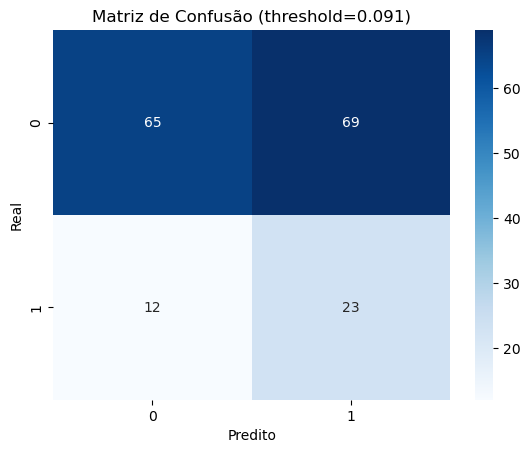

In [49]:
# 1. Gerar as probabilidades
y_proba = modelo_final.predict_proba(X_test)[:, 1]

# 2. Encontrar melhor limiar com base na curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)
melhor_threshold = thresholds[ix]
print(f'Melhor limiar pela curva ROC: {melhor_threshold:.3f}')

# 3. Aplicar limiar
y_pred_threshold = (y_proba >= melhor_threshold).astype(int)

# 4. Matriz de confusão
matriz = confusion_matrix(y_test, y_pred_threshold)
print(matriz)

# 5. Plotar matriz
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão (threshold={melhor_threshold:.3f})')
plt.show()
